In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.utils.data.dataset import random_split
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle as pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from itertools import cycle
import torchvision.models as models
colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

In [2]:
#########################################################################################
#set the seed for random environment
#here we set the seed to 42
#########################################################################################
def seed_everything(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
#when import the module the seed is set
seed_everything()

In [3]:
batch_size = 64

## Dataset Preparation ##

In [9]:
class WaveFormDataset(Dataset):
    def __init__(self, root_dir):
        """
        root_dir: 数据集的根目录
        """
        self.samples = []
        self.labels = []

        # 自动发现数据和标签
        for label in ['noise', 'internal', 'corona']:
            data_dir = os.path.join(root_dir, label)
            for file in os.listdir(data_dir):
                file_path = os.path.join(data_dir, file)
                if file.endswith('.csv'):
                    # 读取CSV文件，跳过表头
                    data = pd.read_csv(file_path, header=None, skiprows=1, sep='[,\t]', engine='python').values
                    # 对于文件中的每一行，保存为一个独立的样本
                    for row in data:
                        self.samples.append(row.astype(np.float32))
                        self.labels.append(label)
        
        # 将文本标签转换为整数
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # 返回单个样本和标签
        sample = self.samples[idx]
        sample = torch.tensor(sample, dtype=torch.float32)
        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.float32)
        return sample, label

# 使用示例
root_dir = '/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/dataset' # 根据实际路径调整
WaveForm = WaveFormDataset(root_dir=root_dir)


In [10]:
# 假设 dataset 是你的完整数据集
dataset_size = len(WaveForm)
train_size = int(dataset_size * 0.7) # 70% 数据用于训练
val_size = int(dataset_size * 0.15) # 15% 数据用于验证
test_size = dataset_size - train_size - val_size # 剩下的 15% 数据用于测试

train_dataset, val_dataset, test_dataset = random_split(WaveForm, [train_size, val_size, test_size])


## DataLoader 

In [11]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [13]:
sample, label = train_loader.dataset[0]
sample.shape


tensor([ -0.4100,  -0.5400,  -0.8200,  -0.6800,  -0.5400,  -0.4100,  -0.9500,
         -0.2700,  -0.1400,  -0.5400,  -0.4100,  -0.5400,  -0.6800,  -0.9500,
         -0.5400,  -0.6800,  -0.5400,  -0.5400,  -0.5400,  -0.6800,  -0.5400,
         -0.8200,  -0.2700,  -0.5400,  -1.0900,  -0.8200,  -0.5400,  -0.8200,
         -0.6800,  -0.5400,  -0.6800,  -1.5000, -12.2400,  -7.6200,  -3.9400,
         -4.0800,  -1.9000,  -1.5000,  -0.8200,  -0.2700,   0.4100,   0.8200,
          1.7700,   0.1400,   0.8200,   0.5400,   1.3600,   0.9500,   1.2200,
          1.0900,   0.6800,   0.9500,   0.2700,   0.5400,   0.5400,   0.1400,
          0.5400,   0.1400,   0.2700,   0.2700,  -0.4100,  -0.2700,  -0.2700,
          0.0000,  -0.1400,  -0.2700,  -0.4100,  -0.5400,  -0.6800,  -0.5400,
         -0.6800,  -0.2700,  -0.4100,  -0.6800,  -0.6800,  -0.5400,  -0.4100,
         -0.6800,  -0.8200,  -0.6800,  -0.5400,  -0.2700,  -0.5400,  -0.5400,
         -0.5400,  -1.3600,  -0.9500,  -0.6800,  -0.8200,  -0.95

In [40]:
len(train_loader.dataset[0][0])

256

## Model

### FCN

In [14]:
CHECKPOINT=False

In [15]:
# Define the FCN model
class FourLayerFCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FourLayerFCN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # 添加dropout层，dropout率为0.5
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # 在激活函数后添加dropout
        x = self.relu(self.fc2(x))
        x = self.dropout(x)  # 在激活函数后添加dropout
        x = self.relu(self.fc3(x))
        x = self.dropout(x)  # 在激活函数后添加dropout
        x = self.fc4(x)
        return x

In [16]:
# Define the input size, hidden size, and number of classes
input_size = len(train_loader.dataset[0][0])
hidden_size = 128
num_classes = 3

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Create an instance of the FourLayerFCN model
model = FourLayerFCN(input_size, hidden_size, num_classes)
model = model.to(device)

In [18]:
# Print the model architecture
summary(model, (input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          32,896
              ReLU-2                  [-1, 128]               0
           Dropout-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
              ReLU-5                  [-1, 128]               0
           Dropout-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                    [-1, 3]             387
Total params: 66,307
Trainable params: 66,307
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.25
Estimated Tot

In [19]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Define the training function
def FCNtrain(model, train_loader, val_loader, num_epochs, criterion, optimizer):
    # Training loop
    total_loss = 0
    total_samples = 0
    total_correct = 0
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        for i, (samples, labels) in enumerate(train_loader):
            samples = samples.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(samples)
            loss = criterion(outputs, labels.long())
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Statistics
            total_loss += loss.item()
            total_samples += labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
        train_loss = total_loss / total_samples
        train_losses.append(train_loss)
        # Validation
        model.eval()
        with torch.no_grad():
            total_loss = 0
            total_samples = 0
            total_correct = 0
            for i, (samples, labels) in enumerate(val_loader):
                samples = samples.to(device)
                labels = labels.to(device)
                # Forward pass
                outputs = model(samples)
                loss = criterion(outputs, labels.long())
                # Statistics
                total_loss += loss.item()
                total_samples += labels.size(0)
                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == labels).sum().item()
            val_loss = total_loss / total_samples
            val_losses.append(val_loss)
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Val Loss: {val_loss:.4f}')
        torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, f'/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/checkpoint/FCN/checkpoint_{epoch}.pth')

    return train_losses, val_losses

In [21]:
# Train the model
num_epochs = 10
train_losses, val_losses = (FCNtrain(model, train_loader, val_loader, num_epochs, criterion, optimizer))

Epoch [1/10], Train Loss: 0.0006, Val Loss: 0.0001
Epoch [2/10], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [3/10], Train Loss: 0.0001, Val Loss: 0.0000
Epoch [4/10], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [5/10], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [6/10], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [7/10], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [8/10], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [9/10], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [10/10], Train Loss: 0.0001, Val Loss: 0.0001


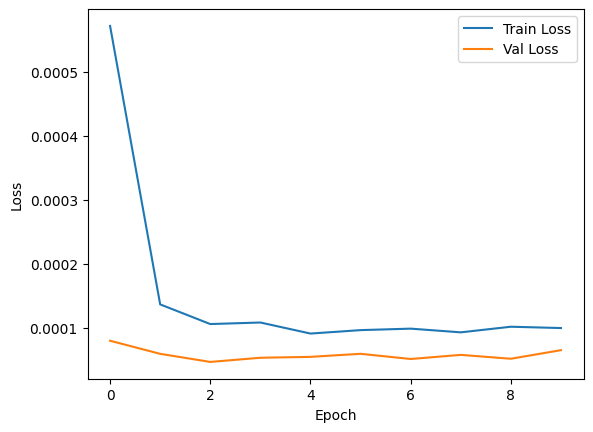

In [22]:
# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
if CHECKPOINT: 
    checkpoint = torch.load('checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

In [23]:
model.eval()
total_samples = 0
total_correct = 0
with torch.no_grad():
    for samples, labels in test_loader:
        samples = samples.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(samples)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

test_accuracy = total_correct / total_samples
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9996


### RESNET

In [41]:
# Define the ResNet model
resnet = models.resnet18(pretrained=False)
num_ftrs = resnet.fc.in_features
resnet.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet.fc = nn.Linear(num_ftrs, num_classes)
resnet = resnet.to(device)

# Print the model architecture
summary(resnet, (1, input_size))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

# Train the model
num_epochs = 10
train_losses, val_losses = train(resnet, train_loader, val_loader, num_epochs, criterion, optimizer)

/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [42]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [46]:
resnet = resnet.to(device)

In [47]:
# Print the model architecture
print(resnet)
summary(resnet, (1, input_size))

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (c

ValueError: expected 4D input (got 3D input)

In [ ]:
# Train the model
num_epochs = 10
train_losses, val_losses = train(model, train_loader, val_loader, num_epochs, criterion, optimizer)

# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
model.eval()
total_samples = 0
total_correct = 0
with torch.no_grad():
    for samples, labels in test_loader:
        samples = samples.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(samples)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

test_accuracy = total_correct / total_samples
print(f'Test Accuracy: {test_accuracy:.4f}')


### SVM

In [ ]:

# Load the data
X_train = []
y_train = []
for samples, labels in train_loader:
    samples = samples.numpy()
    labels = labels.numpy()
    X_train.extend(samples)
    y_train.extend(labels)
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = []
y_val = []
for samples, labels in val_loader:
    samples = samples.numpy()
    labels = labels.numpy()
    X_val.extend(samples)
    y_val.extend(labels)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = []
y_test = []
for samples, labels in test_loader:
    samples = samples.numpy()
    labels = labels.numpy()
    X_test.extend(samples)
    y_test.extend(labels)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train the SVM model
model = svm.SVC(kernel='rbf', C=1, gamma='auto')
model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = np.mean(y_val_pred == y_val)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the model on the test set
y_test_pred = model.predict(X_test)
test_accuracy = np.mean(y_test_pred == y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:

# Plot the ROC curve
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
y_test = y_test.astype(int)
y_test_pred = y_test_pred.astype(int)
y_test_one_hot = np.eye(n_classes)[y_test]
y_test_pred_one_hot = np.eye(n_classes)[y_test_pred]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_test_pred_one_hot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
